In [1]:
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
from datetime import datetime
from shapely.geometry import shape
from shapely.wkt import loads

import urllib.request as request
import json 

In [4]:
import sys
sys.path.append('../src')

from visualisation import plot_water_body
from geom_utils import get_bbox, get_optimal_resolution
from sh_requests import get_optical_data, get_S2_request, get_S2_wmsrequest
from s2_water_extraction import extract_surface_water_area_per_frame, surface_water_area_with_dem_veto

# Surface water level extraction example

This notebook demonstrates how to run water detection algorithm and extract surface water level for a single reservoir in a given time interval. The neccessary input is:
* shapely polygon of reservoir's nominal outline,
* time.

Requirements: Sentinel Hub account (trial available and sufficient) with configuration based on Python scripts template. See [README](https://github.com/sentinel-hub/eo-learn/blob/master/examples/README.md) for more detailed instructions.

## Inputs

In this example we'll extract surface water level of [Wemmershoek Dam](https://water.blue-dot-observatory.com/38419) in South Africa on May 31, 2017. We can obtain the dam's nominal outline using Bluedot water observatory's API.

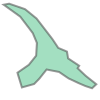

In [5]:
time_interval = ['2017-05-31','2017-05-31'] 

wb_url = 'https://water.blue-dot-observatory.com/api/waterbodies/38419/index.html'
with request.urlopen(wb_url) as url:
    wb_data = json.loads(url.read().decode())
    
nominal_outline = shape(wb_data['nominal_outline']['geometry'])
nominal_outline

In [6]:
date = datetime(2017,5,31)
the_dam_bbox = get_bbox(nominal_outline)
resx, resy = get_optimal_resolution(the_dam_bbox)

measurement = extract_surface_water_area_per_frame(42, nominal_outline, the_dam_bbox, date, resx, resy)

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:312: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com


In [7]:
measurement.SURF_WATER_LEVEL

1.7940739019875056

In [8]:
detected_water = loads(measurement.GEOMETRY)

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com


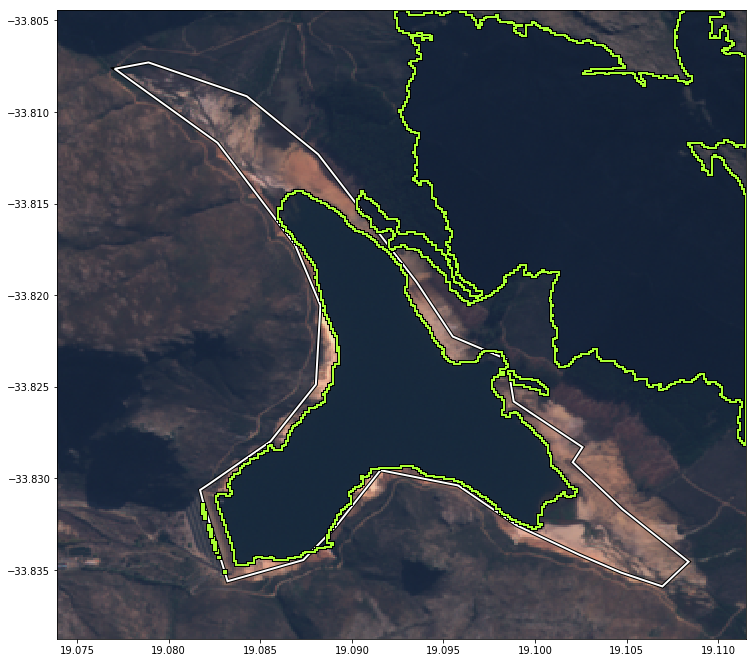

In [9]:
plot_water_body(get_optical_data(get_S2_request('TRUE-COLOR-S2-L1C',the_dam_bbox,date,resx, resy, 0.2)), 
                date, nominal_outline, the_dam_bbox, detected_water, measurement.SURF_WATER_LEVEL)

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com


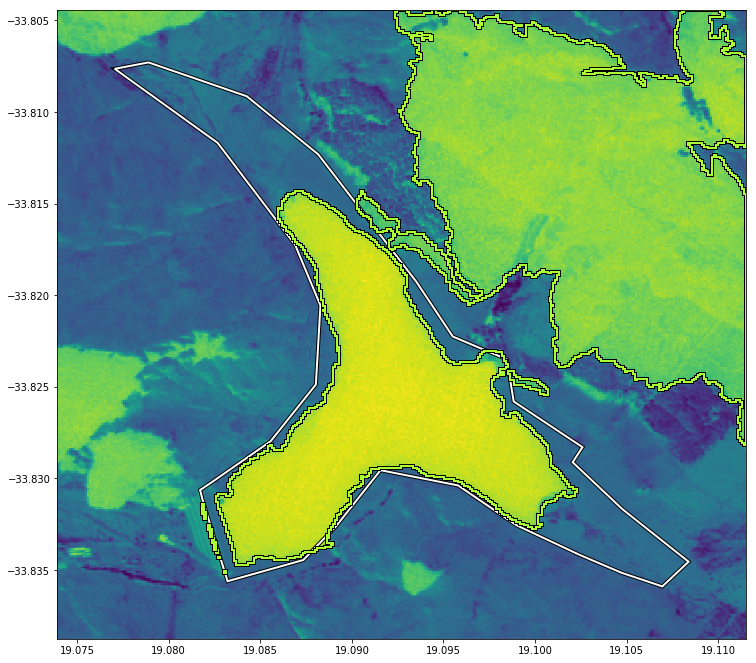

In [10]:
plot_water_body(get_optical_data(get_S2_request('NDWI',the_dam_bbox,date,resx, resy, 0.2)), 
                date, nominal_outline, the_dam_bbox, detected_water, measurement.SURF_WATER_LEVEL)

As can be seen the topographic shadow has been detected as water in this case. Apply DEM veto to fix this false positive.

In [11]:
measurement_with_dem = surface_water_area_with_dem_veto(measurement, nominal_outline, the_dam_bbox, resx, resy, 15)

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services-uswest2.sentinel-hub.com


In [12]:
measurement_with_dem.SURF_WATER_LEVEL

0.6230506861822421

In [13]:
detected_water_with_dem = loads(measurement_with_dem.GEOMETRY)

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com


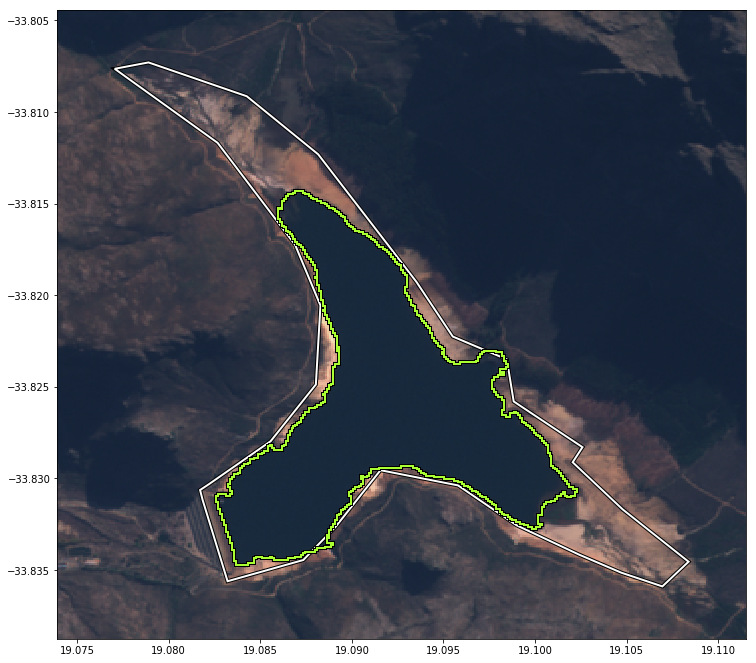

In [14]:
plot_water_body(get_optical_data(get_S2_request('TRUE-COLOR-S2-L1C',the_dam_bbox,date,resx, resy, 0.2)), 
                date, nominal_outline, the_dam_bbox, detected_water_with_dem, measurement_with_dem.SURF_WATER_LEVEL)

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): services.sentinel-hub.com


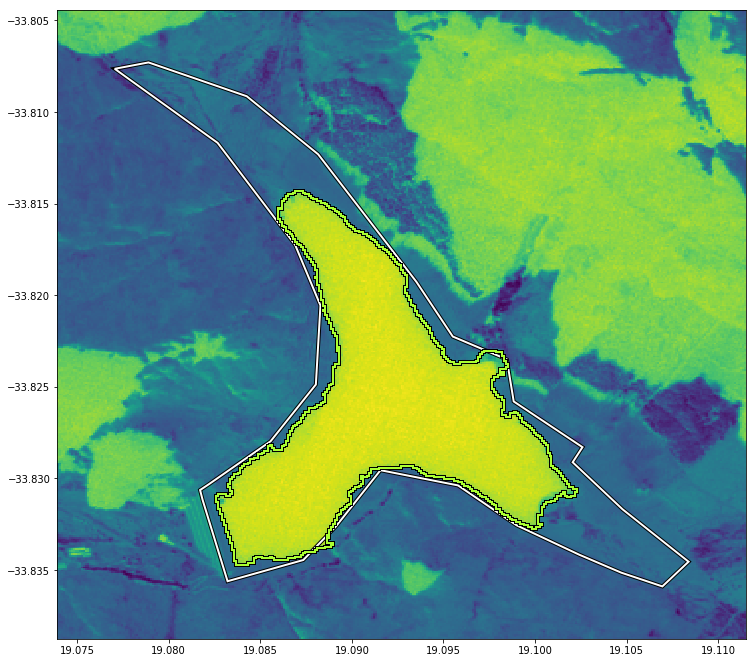

In [15]:
plot_water_body(get_optical_data(get_S2_request('NDWI',the_dam_bbox,date,resx, resy, 0.2)), 
                date, nominal_outline, the_dam_bbox, detected_water_with_dem, measurement_with_dem.SURF_WATER_LEVEL)